## IMPORTING LIBRARIES

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## DATA VISUALISATION

In [60]:
df = pd.read_csv("HR_capstone_dataset.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


We have same amount of non-null values which is good for our clear process. Our data looks very healthy. Department and salary are dtype of object further on we deal with it and make it readable for our model

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Graphs below shows us even distribution of salary is abundant in low class the satisfaction level is high.

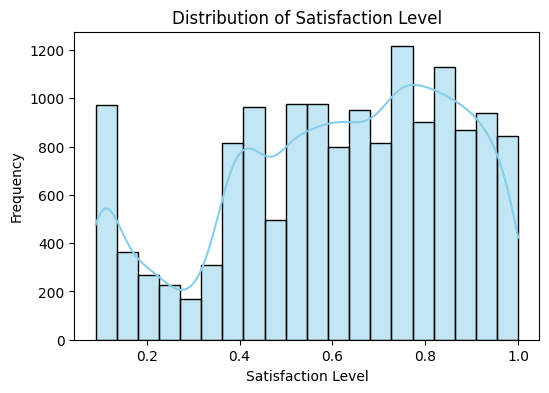

C:\Users\MrOmu\AppData\Local\Temp\ipykernel_8152\3108626857.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='salary', palette='muted')


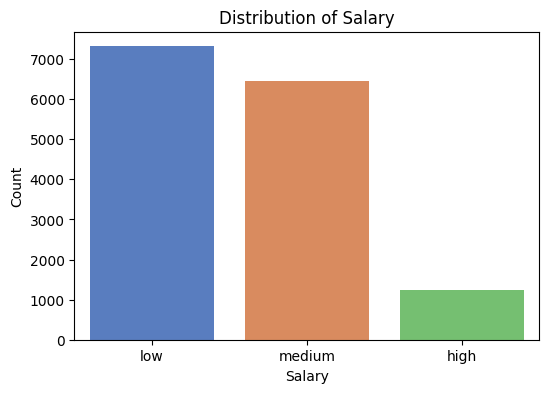

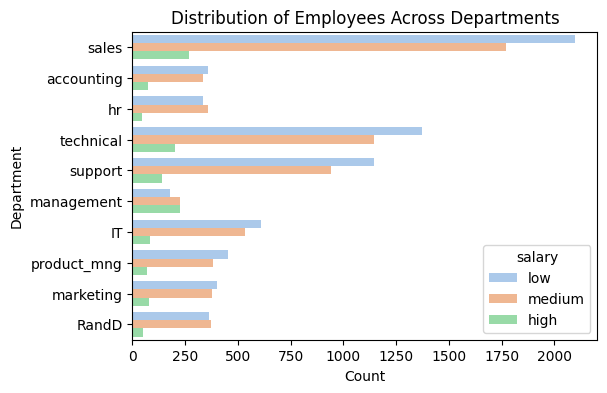

In [62]:

# Plotting the distribution of satisfaction_level
plt.figure(figsize=(6, 4))
sns.histplot(df['satisfaction_level'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of salary
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='salary', palette='muted')
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of employees across different departments
plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='Department', palette='pastel',hue="salary")
plt.title('Distribution of Employees Across Departments')
plt.xlabel('Count')
plt.ylabel('Department')
plt.show()

We clearly see that if worker's satisfaction level is higher than 0.5 worker tend to stay.

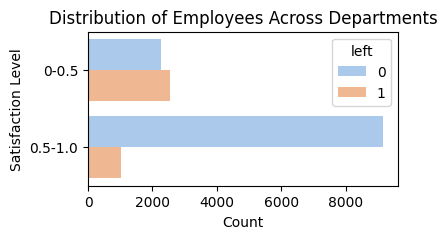

In [63]:

plt.figure(figsize=(4, 2))
sns.countplot(data=df, y=pd.cut(df['satisfaction_level'], bins=[0, 0.5, 1.0], labels=['0-0.5', '0.5-1.0']),hue="left", palette='pastel')
plt.title('Distribution of Employees Across Departments')
plt.xlabel('Count')
plt.ylabel('Satisfaction Level')
plt.show()

Graph shows that working hours and salary correlation. There is no clear relation between them. It may because we have 10 different areas on our dataset. And every line of work has a different working hours

<Axes: xlabel='average_montly_hours', ylabel='count'>

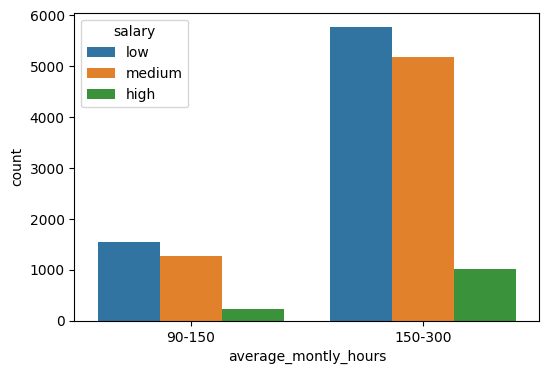

In [64]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x=pd.cut(df['average_montly_hours'], bins=[90, 150, 310], labels=['90-150', '150-300']),hue="salary")

The graph indicates that as salary increases, satisfaction level rises.

C:\Users\MrOmu\AppData\Local\Temp\ipykernel_8152\2459161394.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  sns.violinplot(x='salary', y='satisfaction_level', data=df,hue="salary",color="red")


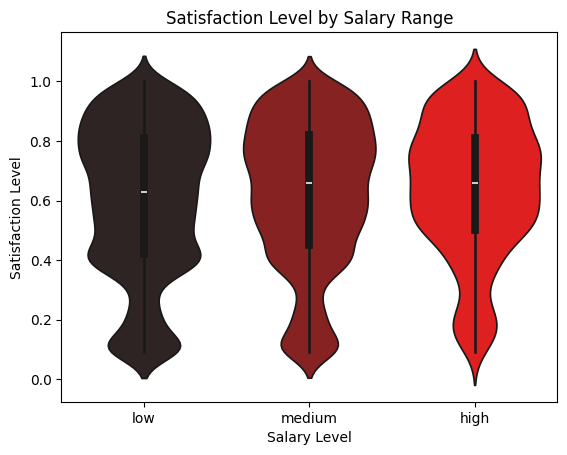

In [65]:
sns.violinplot(x='salary', y='satisfaction_level', data=df,hue="salary",color="red")
plt.title('Satisfaction Level by Salary Range')
plt.xlabel('Salary Level')
plt.ylabel('Satisfaction Level')
plt.show()

For our workers our data has a very distinctive values with "avarage_montly_hours" starting from 90 to 310. But when it comes to mean it is clear every line of job working almost same amount of time.

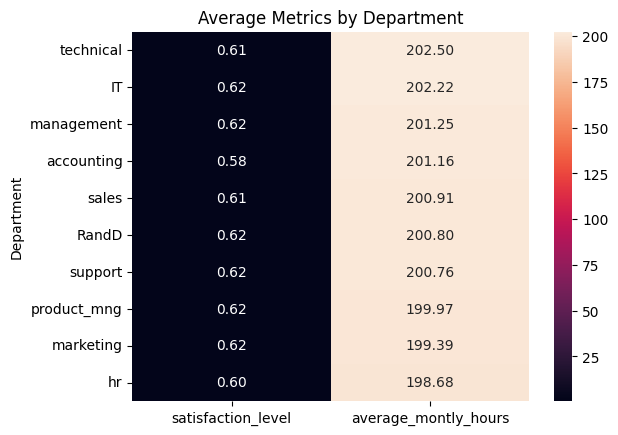

In [66]:
department_metrics = df.groupby('Department').agg({
    'satisfaction_level': 'mean',
    'average_montly_hours': 'mean'
}).sort_values(by='average_montly_hours', ascending=False)

sns.heatmap(department_metrics, annot=True, fmt=".2f")
plt.title('Average Metrics by Department')
plt.show()

# PREPROCESSING DATA

## Encoding Our Object Type Columns

In [67]:

# Initialize a label encoder object
encoder = LabelEncoder()

# Encoding the 'department',"salary" column
df["Department"] = encoder.fit_transform(df["Department"])
df["salary"] = encoder.fit_transform(df["salary"])

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


## Splitting Our Data Test and Train

In [68]:
X = df.drop(columns="left",axis=1)
y = df["left"]

In [69]:

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

## Scaling Our Data if Necessary

In [70]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train[["average_montly_hours"]] = sc.fit_transform(X_train[["average_montly_hours"]])
# X_test[["average_montly_hours"]] = sc.fit_transform(X_test[["average_montly_hours"]])

In [71]:

# mmsc = MinMaxScaler()
# X_train[["number_project"]] = sc.fit_transform(X_train[["number_project"]])
# X_test[["number_project"]] = sc.fit_transform(X_test[["number_project"]])
# X_train[["time_spend_company"]] = sc.fit_transform(X_train[["time_spend_company"]])
# X_test[["time_spend_company"]] = sc.fit_transform(X_test[["time_spend_company"]])


# Our Models

### XGB

In [72]:


model = XGBClassifier()

model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 98.77%
[[2282   12]
 [  25  681]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2294
           1       0.98      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



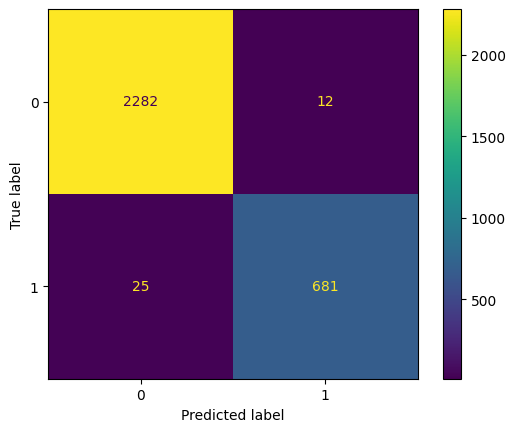

In [73]:

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_xgb, labels=model.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=model.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

### Random Forest Classifier

In [74]:

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rfc)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_rfc))
print(classification_report(y_test,y_pred_rfc))


Accuracy: 98.87%
[[2286    8]
 [  26  680]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2294
           1       0.99      0.96      0.98       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



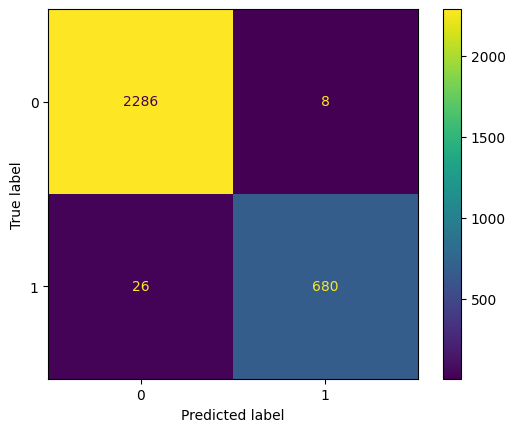

In [75]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_rfc, labels=rfc.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=rfc.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

### Ada Boost Classifier

In [76]:

ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_ada)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))


C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 96.13%
[[2242   52]
 [  64  642]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2294
           1       0.93      0.91      0.92       706

    accuracy                           0.96      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.96      0.96      0.96      3000



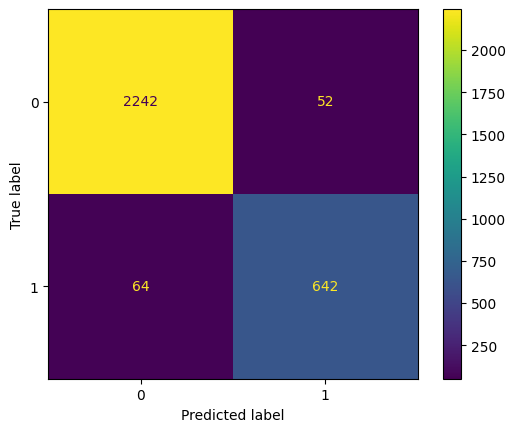

In [77]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_ada, labels=ada.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=ada.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [78]:

cv_score_xgb = cross_val_score(model, X_train, y_train, cv=5)
cv_score_ada = cross_val_score(ada, X_train, y_train, cv=5) 
cv_score_rfc = cross_val_score(rfc, X_train, y_train, cv=5) 
print(cv_score_xgb)
print(cv_score_ada)
print(cv_score_rfc)

C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\MrO

[0.98333333 0.98833333 0.98833333 0.98916667 0.98666111]
[0.95875    0.95916667 0.95708333 0.96291667 0.95956649]
[0.99041667 0.99       0.98916667 0.99333333 0.99124635]


## GridSearch Optimization

In [79]:

# Define the hyperparameter grid for each classifier
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# Create the GridSearchCV objects for each classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
ada_grid_search = GridSearchCV(AdaBoostClassifier(), ada_param_grid, cv=5)
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)

# Fit the GridSearchCV objects to the data
rf_grid_search.fit(X_train, y_train)
ada_grid_search.fit(X_train, y_train)
xgb_grid_search.fit(X_train, y_train)

# Print the best parameters and best score for each classifier
print("RandomForestClassifier - Best Parameters:", rf_grid_search.best_params_)
print("RandomForestClassifier - Best Score:", rf_grid_search.best_score_)
print("\nAdaBoostClassifier - Best Parameters:", ada_grid_search.best_params_)
print("AdaBoostClassifier - Best Score:", ada_grid_search.best_score_)
print("\nXGBClassifier - Best Parameters:", xgb_grid_search.best_params_)
print("XGBClassifier - Best Score:", xgb_grid_search.best_score_)

C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\MrOmu\anaconda3\lib\site-packa

RandomForestClassifier - Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier - Best Score: 0.9912494094761707

AdaBoostClassifier - Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 50}
AdaBoostClassifier - Best Score: 0.959496630540503

XGBClassifier - Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
XGBClassifier - Best Score: 0.9894156940391831


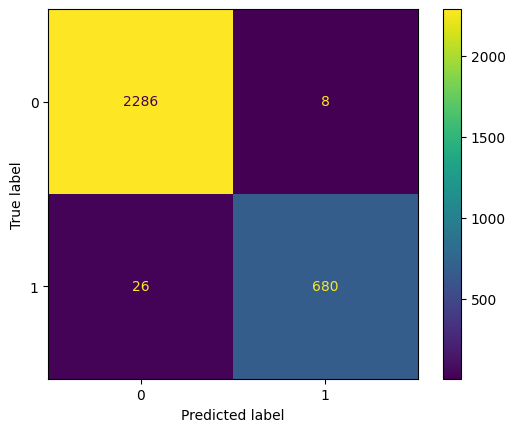

In [80]:
rfc_model = RandomForestClassifier(max_depth = None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split =  2, n_estimators= 200)
rfc_model.fit(X_train,y_train)
rfc_predict_y = rfc_model.predict(X_test)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, rfc_predict_y, labels=rfc_model.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=rfc_model.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

C:\Users\MrOmu\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


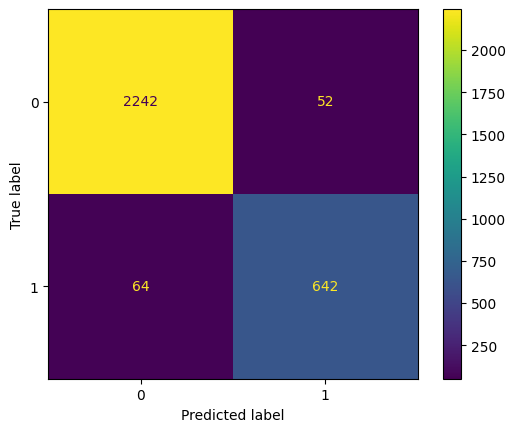

In [81]:
ada_model = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1.0, n_estimators= 50)
ada_model.fit(X_train,y_train)
ada_predict_y = ada_model.predict(X_test)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, ada_predict_y, labels=ada_model.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=ada_model.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

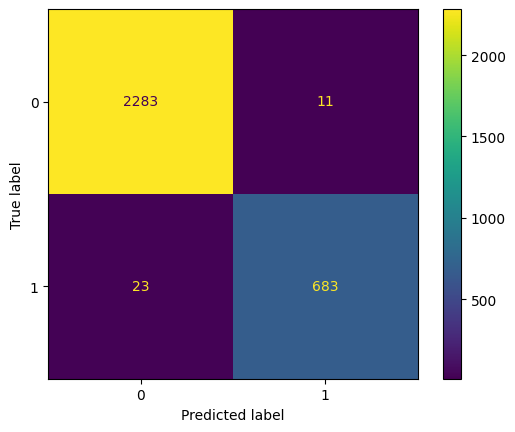

In [82]:
xgb_model = XGBClassifier( learning_rate =  0.3, max_depth = 7, n_estimators = 100, subsample= 1.0)
xgb_model.fit(X_train,y_train)
xgb_predict_y = xgb_model.predict(X_test)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, xgb_predict_y, labels=xgb_model.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=xgb_model.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

Confusion matrices show that our models perform very well. However, GridSearch did not improve our results; in fact, it worsened them. Applying GridSearch's best parameters increased both our false positives and false negatives. Among our models, RandomForestClassifier has the lowest error rate (8 false positives, 26 false negatives).